In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import os
from scipy.stats import linregress
import statsmodels.formula.api as smf
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, LogFormatter
from matplotlib.patches import Patch

BASE_RESULTS_DIR = "experiment_data_test_v1/" 

## Poisson

--- Analyzing Results for: Poisson ---
Successfully loaded and parsed 80 total runs for Poisson.

--- Aggregated Results (Mean over Seeds) ---
   pde_name activation_str  width  depth  final_L2_err_rel_mean  final_L2_err_rel_std  final_total_loss_mean  final_total_loss_std  final_L2_err_rel_sem  final_total_loss_sem
0   Poisson           relu     16      1               1.008477              0.478939           4.998871e-01          2.184606e-04              0.214188          9.769854e-05
1   Poisson           relu     32      1               0.968291              0.360757           4.999980e-01          4.060746e-06              0.161335          1.816021e-06
2   Poisson           relu     64      1               1.085828              0.330510           4.999985e-01          3.622018e-06              0.147809          1.619816e-06
3   Poisson           relu    128      1               1.049375              0.342188           5.000000e-01          2.665601e-08              0.153031     

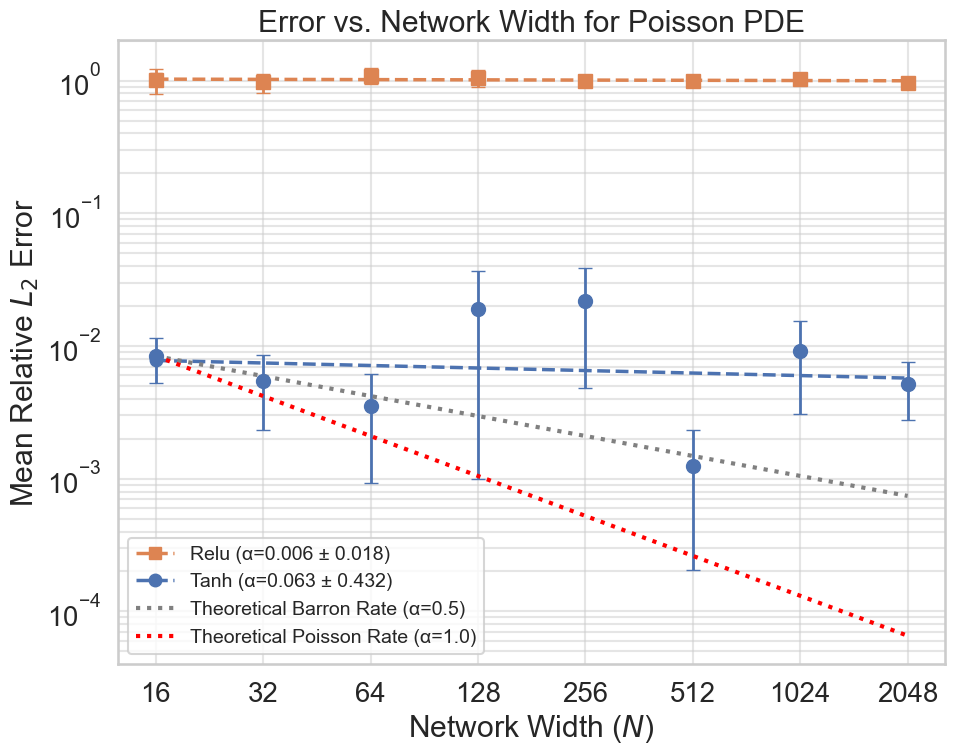

In [11]:
PDE_TO_ANALYZE = "Poisson"

print(f"--- Analyzing Results for: {PDE_TO_ANALYZE} ---")
search_path = os.path.join(BASE_RESULTS_DIR, PDE_TO_ANALYZE, "*", "*", "*", "*", "seed_*")
run_directories = glob.glob(search_path)

if not run_directories:
    print(f"Error: No run directories found for {PDE_TO_ANALYZE} at path: {search_path}")
    raise FileNotFoundError("No data found. Check BASE_RESULTS_DIR and that experiments have completed.")

all_results = []
for run_dir in run_directories:
    config_path = os.path.join(run_dir, "config.json")
    log_path = os.path.join(run_dir, "training_log.csv")

    if not (os.path.exists(config_path) and os.path.exists(log_path)):
        print(f"Warning: Missing config.json or training_log.csv in {run_dir}. Skipping.")
        continue

    # Load the configuration for this run
    with open(config_path, 'r') as f:
        config = json.load(f)

    # Load the training log and get the final row for final metrics
    try:
        log_df = pd.read_csv(log_path)
        if not log_df.empty:
            final_metrics = log_df.iloc[-1].to_dict()
        else:
            print(f"Warning: training_log.csv is empty in {run_dir}. Skipping.")
            continue
    except pd.errors.EmptyDataError:
        print(f"Warning: training_log.csv is empty in {run_dir}. Skipping.")
        continue
    
    # Combine config and final metrics into a single record
    run_record = {
        'pde_name': config.get('pde_name'),
        'activation_str': config.get('activation_str'),
        'width': config.get('width'),
        'depth': config.get('depth'),
        'seed': config.get('seed'),
        'final_L2_err_rel': final_metrics.get('L2_err_rel'),
        'final_total_loss': final_metrics.get('loss_total'),
        'final_PDE_residual_max': final_metrics.get('PDE_residual_max'),
        'total_time_s': final_metrics.get('time_s')
    }
    all_results.append(run_record)

master_df = pd.DataFrame(all_results)
print(f"Successfully loaded and parsed {len(master_df)} total runs for {PDE_TO_ANALYZE}.")
# print("Data head:")
# print(master_df.head())


# Group by all experimental parameters except the seed
agg_cols = ['pde_name', 'activation_str', 'width', 'depth']
metrics_to_agg = ['final_L2_err_rel', 'final_total_loss']

# Calculate mean and standard error of the mean (SEM = std / sqrt(n))
agg_df = master_df.groupby(agg_cols)[metrics_to_agg].agg(['mean', 'std']).reset_index()

# Flatten MultiIndex columns
agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns.values]

# Calculate standard error of the mean for error bars
num_seeds = len(master_df['seed'].unique())
for metric in metrics_to_agg:
    agg_df[f'{metric}_sem'] = agg_df[f'{metric}_std'] / np.sqrt(num_seeds)

print("\n--- Aggregated Results (Mean over Seeds) ---")
print(agg_df.to_string())

print("\n--- Fitting Scaling Law: error ~ N^(-α) ---")

fit_results = {}
for act_str in master_df['activation_str'].unique():
    subset_df = agg_df[agg_df['activation_str'] == act_str].copy()
    
    # Prepare data for log-log regression
    subset_df['log_width'] = np.log(subset_df['width'])
    subset_df['log_error'] = np.log(subset_df['final_L2_err_rel_mean'])
    
    # Drop any rows that might have resulted in NaN/inf
    subset_df.dropna(subset=['log_width', 'log_error'], inplace=True)
    subset_df = subset_df[np.isfinite(subset_df['log_error'])]
    
    if len(subset_df) < 2:
        print(f"Not enough data to fit scaling law for activation: {act_str}")
        continue
        
    slope, intercept, r_value, p_value, std_err = linregress(x=subset_df['log_width'], y=subset_df['log_error'])
    
    alpha = -slope
    logA = intercept
    
    fit_results[act_str] = {
        'alpha': alpha,
        'logA': logA,
        'r_squared': r_value**2,
        'p_value': p_value,
        'alpha_std_err': std_err
    }
    
    print(f"\nResults for activation = '{act_str}':")
    # Confidence Interval for alpha is approx. 1.96 * standard error of the slope
    print(f"  - Fitted alpha (α): {alpha:.4f} ± {1.96 * std_err:.4f} (95% CI)")
    print(f"  - R-squared: {r_value**2:.4f}")

# Generate plot
sns.set_theme(style="whitegrid", context="talk", font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

color_map = {'tanh': 'C0', 'relu': 'C1'}
marker_map = {'tanh': 'o', 'relu': 's'}

for act_str, group in agg_df.groupby('activation_str'):
    # Plot data points with error bars (no label here)
    ax.errorbar(
        x=group['width'],
        y=group['final_L2_err_rel_mean'],
        yerr=group['final_L2_err_rel_sem'],
        linestyle='',
        marker=marker_map.get(act_str, 'D'),
        capsize=5,
        color=color_map.get(act_str),
        elinewidth=2,
        markersize=10
    )
    
    # Plot the fitted line from the regression
    if act_str in fit_results:
        alpha_fit = fit_results[act_str]['alpha']
        logA_fit = fit_results[act_str]['logA']
        std_err_fit = fit_results[act_str]['alpha_std_err']
        
        x_fit = np.logspace(np.log10(group['width'].min()), np.log10(group['width'].max()), 100)
        y_fit = np.exp(logA_fit) * (x_fit ** -alpha_fit)
        
        # This plot call creates the legend entry.
        # We add the marker type here, but tell it to only plot a marker
        # at an index that doesn't exist (len(x_fit) + 1).
        # This makes the marker appear in the legend but not on the line itself.
        ax.plot(x_fit, y_fit,
                label=f"{act_str.capitalize()} (α={alpha_fit:.3f} ± {1.96 * std_err_fit:.3f})",
                color=color_map.get(act_str),
                linestyle='--',
                linewidth=2.5,
                marker=marker_map.get(act_str),
                markevery=len(x_fit) + 1 # Trick to show marker in legend only
               )

# --- Plot Theoretical Benchmark Lines (Anchored to Tanh) ---
tanh_df = agg_df[agg_df['activation_str'] == 'tanh'].sort_values('width')
if not tanh_df.empty:
    first_point = tanh_df.iloc[0]
    x_start_theory = first_point['width']
    y_start_theory = first_point['final_L2_err_rel_mean']
    
    width_range = np.array([agg_df['width'].min(), agg_df['width'].max()])

    y_theory_barron = y_start_theory * (width_range / x_start_theory) ** -0.5
    ax.plot(width_range, y_theory_barron, color='gray', linestyle=':', linewidth=3, label='Theoretical Barron Rate (α=0.5)')

    y_theory_poisson = y_start_theory * (width_range / x_start_theory) ** -1.0
    ax.plot(width_range, y_theory_poisson, color='red', linestyle=':', linewidth=3, label='Theoretical Poisson Rate (α=1.0)')

ax.set_xscale('log', base=2)
ax.set_yscale('log')

widths = sorted(agg_df['width'].unique())
ax.set_xticks(widths)
ax.xaxis.set_major_formatter(ScalarFormatter())

ax.set_xlabel("Network Width ($N$)")
ax.set_ylabel("Mean Relative $L_2$ Error")
ax.set_title(f"Error vs. Network Width for {PDE_TO_ANALYZE} PDE")
ax.legend(fontsize=14)
ax.grid(True, which="both", ls="-", alpha=0.5)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(f"analysis_plot_{PDE_TO_ANALYZE}.pdf", dpi=300, bbox_inches='tight')
fig.savefig(f"analysis_plot_{PDE_TO_ANALYZE}.png", dpi=300, bbox_inches='tight')

## Sine-Gordon

--- Analyzing All Results for: SineGordon ---
Successfully loaded and parsed 560 total runs.

--- Aggregated Results (Mean over Seeds) ---
    activation_str  width  kappa_val  final_L2_err_rel_mean  final_L2_err_rel_std  final_L2_err_rel_sem
0             relu     16       0.25               0.040782              0.008230              0.003681
1             relu     16       0.50               0.055267              0.019200              0.008586
2             relu     16       1.00               0.054797              0.006714              0.003003
3             relu     16       2.00               0.049484              0.023327              0.010432
4             relu     16       4.00               0.081877              0.023198              0.010374
5             relu     16       8.00               0.232597              0.075193              0.033627
6             relu     16      16.00               0.774464              0.217555              0.097293
7             relu     32    

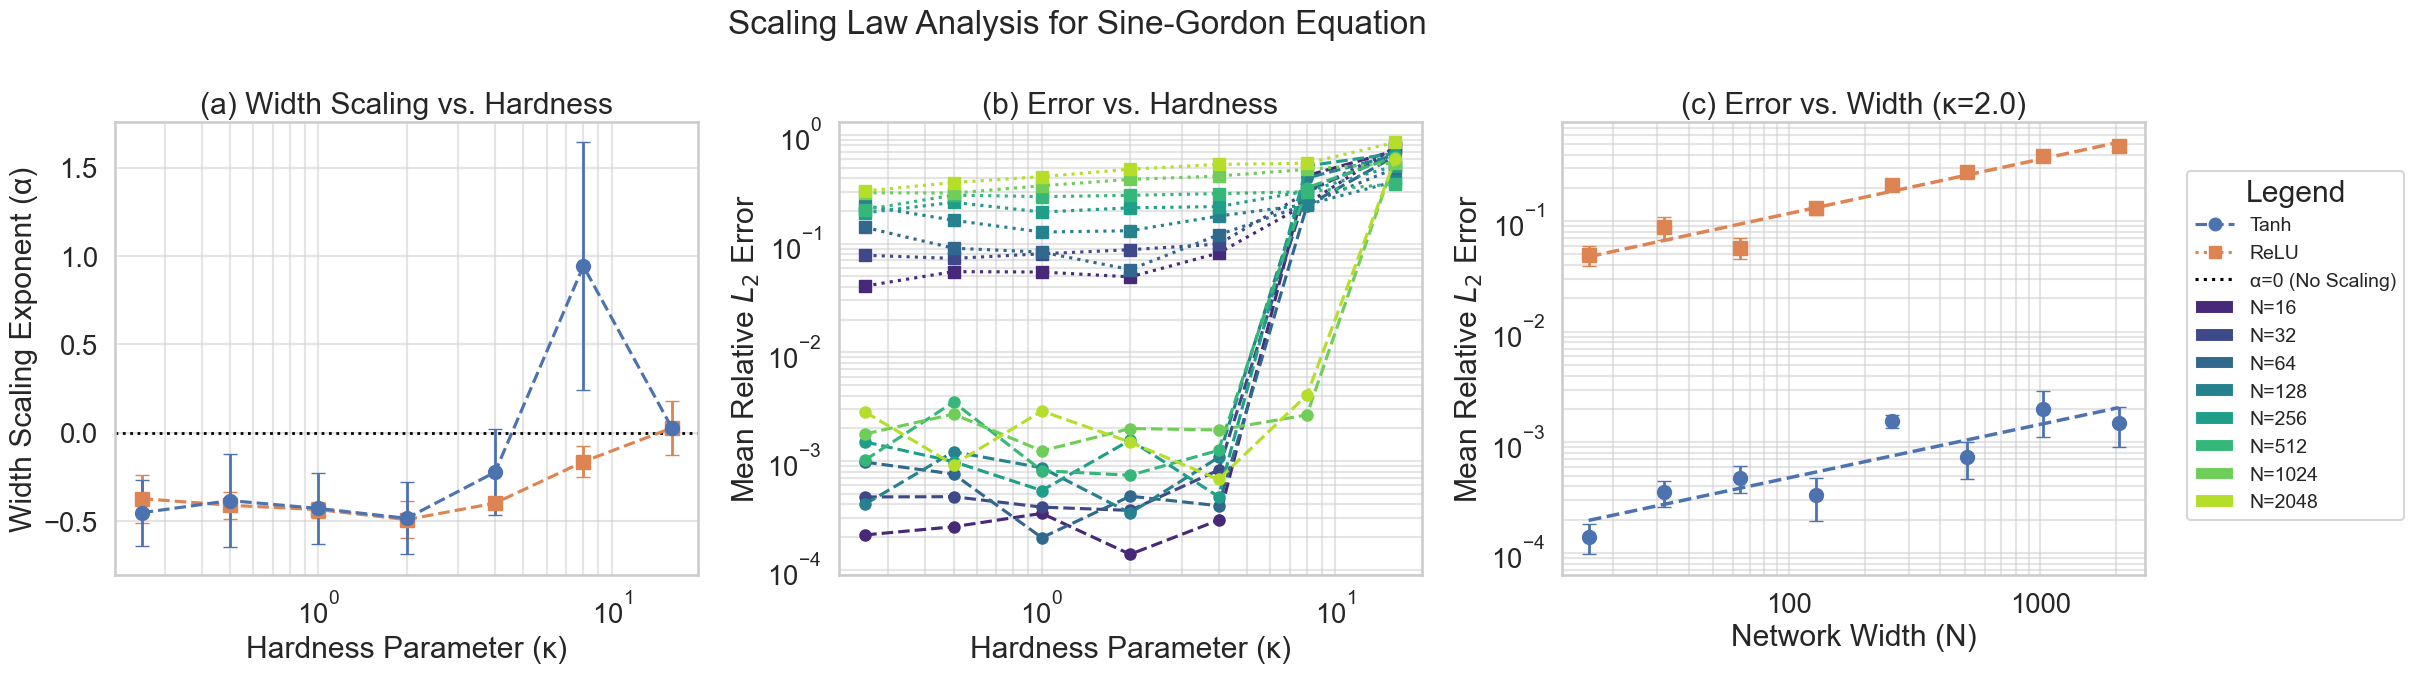

Saved combined summary plot to analysis_summary_plot_SineGordon.png

--- Fitting Multivariate Scaling Law: error ~ A * N**(-alpha) * kappa**gamma ---

--- Multivariate Fit Summary for Activation: relu ---
                            OLS Regression Results                            
Dep. Variable:              log_error   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     63.28
Date:                Wed, 20 Aug 2025   Prob (F-statistic):           9.06e-15
Time:                        22:35:27   Log-Likelihood:                -29.936
No. Observations:                  56   AIC:                             65.87
Df Residuals:                      53   BIC:                             71.95
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
     

In [16]:
PDE_TO_ANALYZE = "SineGordon"


print(f"--- Analyzing All Results for: {PDE_TO_ANALYZE} ---")

search_path = os.path.join(BASE_RESULTS_DIR, PDE_TO_ANALYZE, "*", "*", "*", "*", "seed_*")
run_directories = glob.glob(search_path)

if not run_directories:
    raise FileNotFoundError(f"No run directories found for {PDE_TO_ANALYZE} at path: {search_path}")

all_final_results = []
for run_dir in run_directories:
    config_path = os.path.join(run_dir, "config.json")
    log_path = os.path.join(run_dir, "training_log.csv")

    if not (os.path.exists(config_path) and os.path.exists(log_path)):
        continue

    with open(config_path, 'r') as f:
        config = json.load(f)

    try:
        log_df = pd.read_csv(log_path)
        if log_df.empty:
            continue
    except pd.errors.EmptyDataError:
        continue
    
    final_metrics = log_df.iloc[-1].to_dict()
    run_record = {
        'activation_str': config.get('activation_str'), 'width': config.get('width'),
        'seed': config.get('seed'), 'kappa_val': config.get('kappa_val'),
        'final_L2_err_rel': final_metrics.get('L2_err_rel'),
    }
    all_final_results.append(run_record)

master_df = pd.DataFrame(all_final_results)
print(f"Successfully loaded and parsed {len(run_directories)} total runs.")

# Aggregate data
agg_cols = ['activation_str', 'width', 'kappa_val']
agg_df = master_df.groupby(agg_cols)['final_L2_err_rel'].agg(['mean', 'std']).reset_index()
agg_df.columns = ['activation_str', 'width', 'kappa_val', 'final_L2_err_rel_mean', 'final_L2_err_rel_std']
num_seeds = len(master_df['seed'].unique())
if num_seeds > 1:
    agg_df['final_L2_err_rel_sem'] = agg_df['final_L2_err_rel_std'] / np.sqrt(num_seeds)
else:
    agg_df['final_L2_err_rel_sem'] = 0

alpha_vs_kappa_results = []
for (kappa_val, act_str), group in agg_df.groupby(['kappa_val', 'activation_str']):
    subset_df = group.copy()
    subset_df['log_width'] = np.log(subset_df['width'])
    subset_df['log_error'] = np.log(subset_df['final_L2_err_rel_mean'])
    subset_df.dropna(subset=['log_width', 'log_error'], inplace=True)
    subset_df = subset_df[np.isfinite(subset_df['log_error'])]
    
    if len(subset_df) >= 2:
        slope, intercept, _, _, std_err = linregress(x=subset_df['log_width'], y=subset_df['log_error'])
        alpha_vs_kappa_results.append({
            'kappa_val': kappa_val, 'activation_str': act_str, 
            'alpha': -slope, 'alpha_std_err': std_err, 'logA': intercept
        })
alpha_df = pd.DataFrame(alpha_vs_kappa_results)

# Print full aggregated results ---
print("\n--- Aggregated Results (Mean over Seeds) ---")
print(agg_df.to_string())
print("\n--- Fitted Alpha Values ---")
print(alpha_df.to_string())


# Plotting the combined summary figure
print("\n--- Generating Combined Summary Figure (1x3) ---")
sns.set_theme(style="whitegrid", context="talk", font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(22, 7)) 

color_map = {'tanh': 'C0', 'relu': 'C1'} 
marker_map = {'tanh': 'o', 'relu': 's'}

# Panel 1: Alpha (α) vs. Hardness (κ)
ax = axes[0]
if not alpha_df.empty:
    for act_str, group in alpha_df.groupby('activation_str'):
        ax.errorbar(
            x=group['kappa_val'], y=group['alpha'], yerr=1.96 * group['alpha_std_err'],
            marker=marker_map.get(act_str), linestyle='--', capsize=5, 
            color=color_map.get(act_str), markersize=10, elinewidth=2
        )
ax.set_xscale('log')
ax.axhline(0, color='black', linestyle=':', linewidth=2)
ax.set_title(f"(a) Width Scaling vs. Hardness")
ax.set_xlabel("Hardness Parameter (κ)")
ax.set_ylabel("Width Scaling Exponent (α)")
ax.grid(True, which="both", ls="-", alpha=0.5)

# Panel 2: Error vs. Hardness (κ)
ax = axes[1]
unique_widths = sorted(agg_df['width'].unique())
width_palette = sns.color_palette("viridis", n_colors=len(unique_widths))
width_color_map = {width: color for width, color in zip(unique_widths, width_palette)}

for (width_val, act_str), group in agg_df.groupby(['width', 'activation_str']):
    ax.plot(
        group['kappa_val'], group['final_L2_err_rel_mean'],
        marker=marker_map.get(act_str), linestyle='--' if act_str == 'tanh' else ':',
        markersize=8, color=width_color_map.get(width_val)
    )
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_title("(b) Error vs. Hardness")
ax.set_xlabel("Hardness Parameter (κ)"); ax.set_ylabel("Mean Relative $L_2$ Error")
ax.grid(True, which="both", ls="-", alpha=0.5)

# Panel 3: Representative Error vs. Width
ax = axes[2]
representative_kappa = np.median(agg_df['kappa_val'].unique())
df_for_rep_plot = agg_df[agg_df['kappa_val'] == representative_kappa]

for act_str, group in df_for_rep_plot.groupby('activation_str'):
    ax.errorbar(
        x=group['width'], y=group['final_L2_err_rel_mean'], yerr=group['final_L2_err_rel_sem'],
        linestyle='', marker=marker_map.get(act_str), capsize=5, 
        color=color_map.get(act_str), elinewidth=2, markersize=10
    )
    
    fit_info = alpha_df[(alpha_df['kappa_val'] == representative_kappa) & (alpha_df['activation_str'] == act_str)]
    if not fit_info.empty:
        alpha_fit = fit_info['alpha'].iloc[0]
        logA_fit = fit_info['logA'].iloc[0]
        x_fit = np.logspace(np.log10(group['width'].min()), np.log10(group['width'].max()), 100)
        y_fit = np.exp(logA_fit) * (x_fit ** -alpha_fit)
        ax.plot(x_fit, y_fit, linestyle='--', color=color_map.get(act_str), linewidth=2.5)

ax.set_xscale('log'); ax.set_yscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_title(f"(c) Error vs. Width (κ={representative_kappa})")
ax.set_xlabel("Network Width (N)"); ax.set_ylabel("Mean Relative $L_2$ Error")
ax.grid(True, which="both", ls="-", alpha=0.5)

# Unified Legend for the whole figure 
legend_elements = [
    Line2D([0], [0], color=color_map['tanh'], marker=marker_map['tanh'], ls='--', label='Tanh'),
    Line2D([0], [0], color=color_map['relu'], marker=marker_map['relu'], ls=':', label='ReLU'),
    Line2D([0], [0], color='black', ls=':', label='α=0 (No Scaling)')
]
legend_elements.extend([Patch(facecolor=width_color_map[w], label=f'N={w}') for w in unique_widths])

fig.legend(handles=legend_elements, title="Legend", loc='center left', 
           bbox_to_anchor=(1.0, 0.5), fontsize=14)

fig.suptitle(f"Scaling Law Analysis for Sine-Gordon Equation", fontsize=24)
plt.tight_layout()
plt.show()
fig.savefig(f"analysis_summary_plot_{PDE_TO_ANALYZE}.png", dpi=300, bbox_inches='tight')
print(f"Saved combined summary plot to analysis_summary_plot_{PDE_TO_ANALYZE}.png")

print("\n--- Fitting Multivariate Scaling Law: error ~ A * N**(-alpha) * kappa**gamma ---")
multivariate_results = []
for act_str, group_df in agg_df.groupby('activation_str'):
    fit_df = group_df[['width', 'kappa_val', 'final_L2_err_rel_mean']].copy()
    fit_df['log_error'] = np.log(fit_df['final_L2_err_rel_mean'])
    fit_df['log_width'] = np.log(fit_df['width'])
    fit_df['log_kappa'] = np.log(fit_df['kappa_val'])

    # Drop any rows with non-finite values that can arise from the log transform
    fit_df.dropna(inplace=True)
    fit_df = fit_df[np.isfinite(fit_df['log_error'])]

    if len(fit_df) < 3: # Need at least 3 points to fit a plane
        print(f"Skipping multivariate fit for '{act_str}' due to insufficient data.")
        continue

    formula = "log_error ~ log_width + log_kappa"
    model = smf.ols(formula, data=fit_df)
    results = model.fit()

    alpha_avg = -results.params['log_width']
    gamma = results.params['log_kappa']
    logA = results.params['Intercept']
    multivariate_results.append({
        'activation_str': act_str,
        'alpha_avg': alpha_avg,
        'gamma': gamma,
        'logA': logA
    })
    print(f"\n--- Multivariate Fit Summary for Activation: {act_str} ---")
    print(results.summary())
if multivariate_results:
    multivariate_df = pd.DataFrame(multivariate_results)
    print("\n--- Extracted Global Scaling Law Exponents ---")
    print(multivariate_df.to_string())

## KdV

--- Analyzing All Results for: KdV ---
Successfully loaded and parsed 560 total runs.

--- Aggregated Results (Mean over Seeds) ---
    activation_str  width  kappa_val  final_L2_err_rel_mean  final_L2_err_rel_std  final_L2_err_rel_sem
0             relu     16       0.25               0.387480              0.162154              0.072517
1             relu     16       0.50               0.463356              0.024243              0.010842
2             relu     16       1.00               0.690803              0.080593              0.036042
3             relu     16       2.00               0.901128              0.048812              0.021829
4             relu     16       4.00               0.964887              0.014959              0.006690
5             relu     16       8.00               0.981265              0.010739              0.004803
6             relu     16      16.00               0.989969              0.001460              0.000653
7             relu     32       0.25

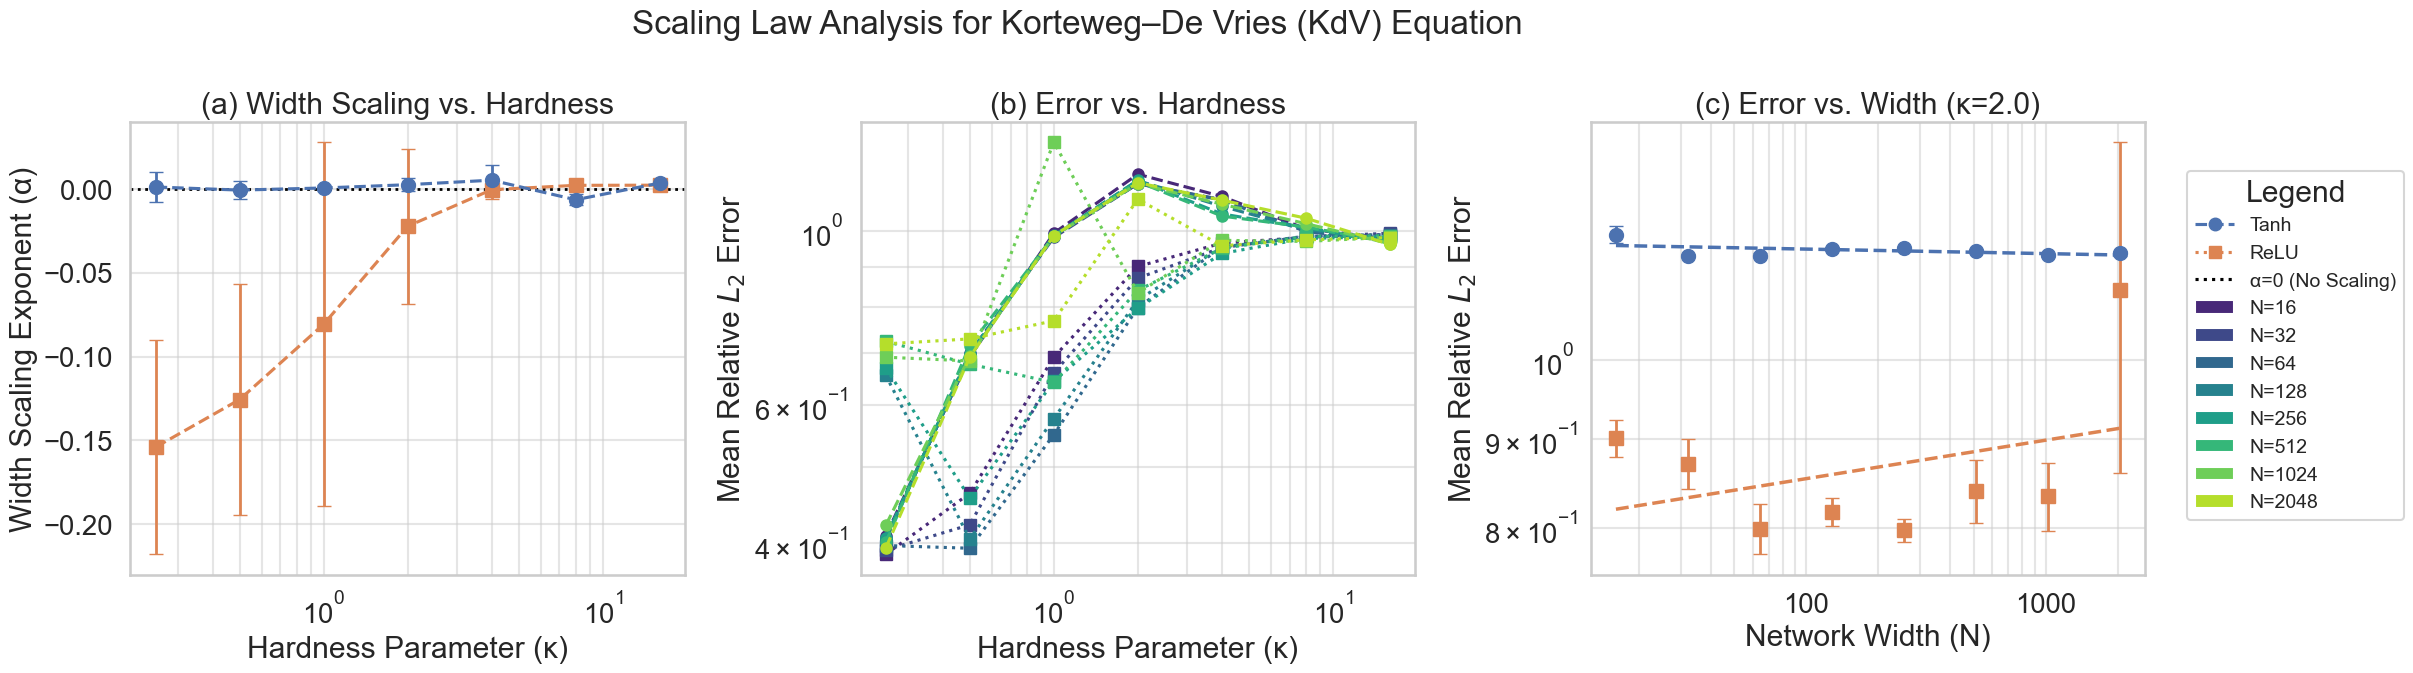

Saved combined summary plot to analysis_summary_plot_KdV.png

--- Fitting Multivariate Scaling Law: error ~ A * N**(-alpha) * kappa**gamma ---

--- Multivariate Fit Summary for Activation: relu ---
                            OLS Regression Results                            
Dep. Variable:              log_error   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     53.08
Date:                Wed, 20 Aug 2025   Prob (F-statistic):           2.21e-13
Time:                        22:22:07   Log-Likelihood:                 17.361
No. Observations:                  56   AIC:                            -28.72
Df Residuals:                      53   BIC:                            -22.65
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
            

In [13]:
PDE_TO_ANALYZE = "KdV"


print(f"--- Analyzing All Results for: {PDE_TO_ANALYZE} ---")

search_path = os.path.join(BASE_RESULTS_DIR, PDE_TO_ANALYZE, "*", "*", "*", "*", "seed_*")
run_directories = glob.glob(search_path)

if not run_directories:
    raise FileNotFoundError(f"No run directories found for {PDE_TO_ANALYZE} at path: {search_path}")

all_final_results = []
for run_dir in run_directories:
    config_path = os.path.join(run_dir, "config.json")
    log_path = os.path.join(run_dir, "training_log.csv")

    if not (os.path.exists(config_path) and os.path.exists(log_path)):
        continue

    with open(config_path, 'r') as f:
        config = json.load(f)

    try:
        log_df = pd.read_csv(log_path)
        if log_df.empty:
            continue
    except pd.errors.EmptyDataError:
        continue
    
    final_metrics = log_df.iloc[-1].to_dict()
    run_record = {
        'activation_str': config.get('activation_str'), 'width': config.get('width'),
        'seed': config.get('seed'), 'kappa_val': config.get('kappa_val'),
        'final_L2_err_rel': final_metrics.get('L2_err_rel'),
    }
    all_final_results.append(run_record)

master_df = pd.DataFrame(all_final_results)
print(f"Successfully loaded and parsed {len(run_directories)} total runs.")

# Aggregate data
agg_cols = ['activation_str', 'width', 'kappa_val']
agg_df = master_df.groupby(agg_cols)['final_L2_err_rel'].agg(['mean', 'std']).reset_index()
agg_df.columns = ['activation_str', 'width', 'kappa_val', 'final_L2_err_rel_mean', 'final_L2_err_rel_std']
num_seeds = len(master_df['seed'].unique())
if num_seeds > 1:
    agg_df['final_L2_err_rel_sem'] = agg_df['final_L2_err_rel_std'] / np.sqrt(num_seeds)
else:
    agg_df['final_L2_err_rel_sem'] = 0

alpha_vs_kappa_results = []
for (kappa_val, act_str), group in agg_df.groupby(['kappa_val', 'activation_str']):
    subset_df = group.copy()
    subset_df['log_width'] = np.log(subset_df['width'])
    subset_df['log_error'] = np.log(subset_df['final_L2_err_rel_mean'])
    subset_df.dropna(subset=['log_width', 'log_error'], inplace=True)
    subset_df = subset_df[np.isfinite(subset_df['log_error'])]
    
    if len(subset_df) >= 2:
        slope, intercept, _, _, std_err = linregress(x=subset_df['log_width'], y=subset_df['log_error'])
        alpha_vs_kappa_results.append({
            'kappa_val': kappa_val, 'activation_str': act_str, 
            'alpha': -slope, 'alpha_std_err': std_err, 'logA': intercept
        })
alpha_df = pd.DataFrame(alpha_vs_kappa_results)

# Print full aggregated results ---
print("\n--- Aggregated Results (Mean over Seeds) ---")
print(agg_df.to_string())
print("\n--- Fitted Alpha Values ---")
print(alpha_df.to_string())


# Plotting the combined summary figure
print("\n--- Generating Combined Summary Figure (1x3) ---")
sns.set_theme(style="whitegrid", context="talk", font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(22, 7)) 

color_map = {'tanh': 'C0', 'relu': 'C1'} 
marker_map = {'tanh': 'o', 'relu': 's'}

# Panel 1: Alpha (α) vs. Hardness (κ)
ax = axes[0]
if not alpha_df.empty:
    for act_str, group in alpha_df.groupby('activation_str'):
        ax.errorbar(
            x=group['kappa_val'], y=group['alpha'], yerr=1.96 * group['alpha_std_err'],
            marker=marker_map.get(act_str), linestyle='--', capsize=5, 
            color=color_map.get(act_str), markersize=10, elinewidth=2
        )
ax.set_xscale('log')
ax.axhline(0, color='black', linestyle=':', linewidth=2)
ax.set_title(f"(a) Width Scaling vs. Hardness")
ax.set_xlabel("Hardness Parameter (κ)")
ax.set_ylabel("Width Scaling Exponent (α)")
ax.grid(True, which="both", ls="-", alpha=0.5)

# Panel 2: Error vs. Hardness (κ)
ax = axes[1]
unique_widths = sorted(agg_df['width'].unique())
width_palette = sns.color_palette("viridis", n_colors=len(unique_widths))
width_color_map = {width: color for width, color in zip(unique_widths, width_palette)}

for (width_val, act_str), group in agg_df.groupby(['width', 'activation_str']):
    ax.plot(
        group['kappa_val'], group['final_L2_err_rel_mean'],
        marker=marker_map.get(act_str), linestyle='--' if act_str == 'tanh' else ':',
        markersize=8, color=width_color_map.get(width_val)
    )
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_title("(b) Error vs. Hardness")
ax.set_xlabel("Hardness Parameter (κ)"); ax.set_ylabel("Mean Relative $L_2$ Error")
ax.grid(True, which="both", ls="-", alpha=0.5)

# Panel 3: Representative Error vs. Width
ax = axes[2]
representative_kappa = np.median(agg_df['kappa_val'].unique())
df_for_rep_plot = agg_df[agg_df['kappa_val'] == representative_kappa]

for act_str, group in df_for_rep_plot.groupby('activation_str'):
    ax.errorbar(
        x=group['width'], y=group['final_L2_err_rel_mean'], yerr=group['final_L2_err_rel_sem'],
        linestyle='', marker=marker_map.get(act_str), capsize=5, 
        color=color_map.get(act_str), elinewidth=2, markersize=10
    )
    
    fit_info = alpha_df[(alpha_df['kappa_val'] == representative_kappa) & (alpha_df['activation_str'] == act_str)]
    if not fit_info.empty:
        alpha_fit = fit_info['alpha'].iloc[0]
        logA_fit = fit_info['logA'].iloc[0]
        x_fit = np.logspace(np.log10(group['width'].min()), np.log10(group['width'].max()), 100)
        y_fit = np.exp(logA_fit) * (x_fit ** -alpha_fit)
        ax.plot(x_fit, y_fit, linestyle='--', color=color_map.get(act_str), linewidth=2.5)

ax.set_xscale('log'); ax.set_yscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_title(f"(c) Error vs. Width (κ={representative_kappa})")
ax.set_xlabel("Network Width (N)"); ax.set_ylabel("Mean Relative $L_2$ Error")
ax.grid(True, which="both", ls="-", alpha=0.5)

# Unified Legend for the whole figure 
legend_elements = [
    Line2D([0], [0], color=color_map['tanh'], marker=marker_map['tanh'], ls='--', label='Tanh'),
    Line2D([0], [0], color=color_map['relu'], marker=marker_map['relu'], ls=':', label='ReLU'),
    Line2D([0], [0], color='black', ls=':', label='α=0 (No Scaling)')
]
legend_elements.extend([Patch(facecolor=width_color_map[w], label=f'N={w}') for w in unique_widths])

fig.legend(handles=legend_elements, title="Legend", loc='center left', 
           bbox_to_anchor=(1.0, 0.5), fontsize=14)

fig.suptitle(f"Scaling Law Analysis for Korteweg–De Vries (KdV) Equation", fontsize=24)
plt.tight_layout()
plt.show()
fig.savefig(f"analysis_summary_plot_{PDE_TO_ANALYZE}.png", dpi=300, bbox_inches='tight')
print(f"Saved combined summary plot to analysis_summary_plot_{PDE_TO_ANALYZE}.png")

print("\n--- Fitting Multivariate Scaling Law: error ~ A * N**(-alpha) * kappa**gamma ---")
multivariate_results = []
for act_str, group_df in agg_df.groupby('activation_str'):
    fit_df = group_df[['width', 'kappa_val', 'final_L2_err_rel_mean']].copy()
    fit_df['log_error'] = np.log(fit_df['final_L2_err_rel_mean'])
    fit_df['log_width'] = np.log(fit_df['width'])
    fit_df['log_kappa'] = np.log(fit_df['kappa_val'])

    # Drop any rows with non-finite values that can arise from the log transform
    fit_df.dropna(inplace=True)
    fit_df = fit_df[np.isfinite(fit_df['log_error'])]

    if len(fit_df) < 3: # Need at least 3 points to fit a plane
        print(f"Skipping multivariate fit for '{act_str}' due to insufficient data.")
        continue

    formula = "log_error ~ log_width + log_kappa"
    model = smf.ols(formula, data=fit_df)
    results = model.fit()

    alpha_avg = -results.params['log_width']
    gamma = results.params['log_kappa']
    logA = results.params['Intercept']
    multivariate_results.append({
        'activation_str': act_str,
        'alpha_avg': alpha_avg,
        'gamma': gamma,
        'logA': logA
    })
    print(f"\n--- Multivariate Fit Summary for Activation: {act_str} ---")
    print(results.summary())
if multivariate_results:
    multivariate_df = pd.DataFrame(multivariate_results)
    print("\n--- Extracted Global Scaling Law Exponents ---")
    print(multivariate_df.to_string())

## AllenCahn

--- Analyzing All Results for: AllenCahn ---
Successfully loaded and parsed 560 total runs.

--- Aggregated Results (Mean over Seeds) ---
    activation_str  width  kappa_val  final_L2_err_rel_mean  final_L2_err_rel_std  final_L2_err_rel_sem
0             relu     16        4.0               0.099052              0.022821              0.010206
1             relu     16        8.0               0.066712              0.019905              0.008902
2             relu     16       16.0               0.044586              0.014417              0.006447
3             relu     16       32.0               0.029283              0.002065              0.000923
4             relu     16       64.0               0.019079              0.014162              0.006334
5             relu     16      128.0               0.018100              0.017058              0.007628
6             relu     16      256.0               0.017446              0.016640              0.007441
7             relu     32     

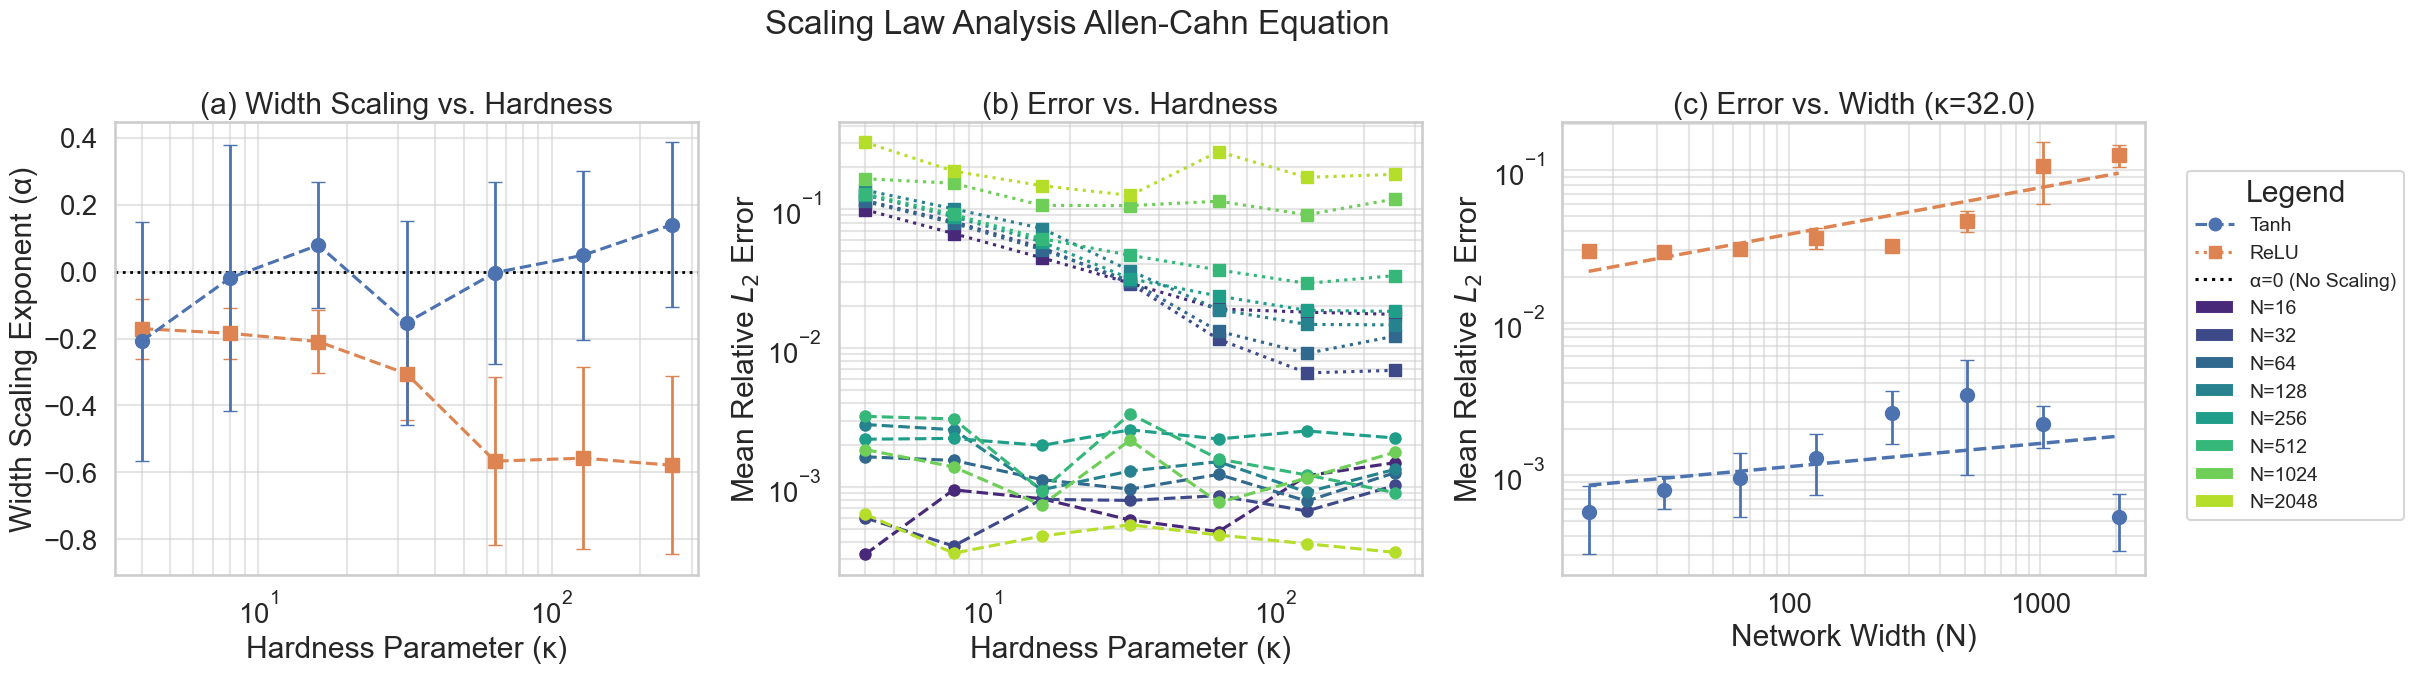

Saved combined summary plot to analysis_summary_plot_AllenCahn.png


In [ ]:
PDE_TO_ANALYZE = "AllenCahn"


print(f"--- Analyzing All Results for: {PDE_TO_ANALYZE} ---")

search_path = os.path.join(BASE_RESULTS_DIR, PDE_TO_ANALYZE, "*", "*", "*", "*", "seed_*")
run_directories = glob.glob(search_path)

if not run_directories:
    raise FileNotFoundError(f"No run directories found for {PDE_TO_ANALYZE} at path: {search_path}")

all_final_results = []
for run_dir in run_directories:
    config_path = os.path.join(run_dir, "config.json")
    log_path = os.path.join(run_dir, "training_log.csv")

    if not (os.path.exists(config_path) and os.path.exists(log_path)):
        continue

    with open(config_path, 'r') as f:
        config = json.load(f)

    try:
        log_df = pd.read_csv(log_path)
        if log_df.empty:
            continue
    except pd.errors.EmptyDataError:
        continue
    
    final_metrics = log_df.iloc[-1].to_dict()
    run_record = {
        'activation_str': config.get('activation_str'), 'width': config.get('width'),
        'seed': config.get('seed'), 'kappa_val': config.get('kappa_val'),
        'final_L2_err_rel': final_metrics.get('L2_err_rel'),
    }
    all_final_results.append(run_record)

master_df = pd.DataFrame(all_final_results)
print(f"Successfully loaded and parsed {len(run_directories)} total runs.")

# Aggregate data
agg_cols = ['activation_str', 'width', 'kappa_val']
agg_df = master_df.groupby(agg_cols)['final_L2_err_rel'].agg(['mean', 'std']).reset_index()
agg_df.columns = ['activation_str', 'width', 'kappa_val', 'final_L2_err_rel_mean', 'final_L2_err_rel_std']
num_seeds = len(master_df['seed'].unique())
if num_seeds > 1:
    agg_df['final_L2_err_rel_sem'] = agg_df['final_L2_err_rel_std'] / np.sqrt(num_seeds)
else:
    agg_df['final_L2_err_rel_sem'] = 0

alpha_vs_kappa_results = []
for (kappa_val, act_str), group in agg_df.groupby(['kappa_val', 'activation_str']):
    subset_df = group.copy()
    subset_df['log_width'] = np.log(subset_df['width'])
    subset_df['log_error'] = np.log(subset_df['final_L2_err_rel_mean'])
    subset_df.dropna(subset=['log_width', 'log_error'], inplace=True)
    subset_df = subset_df[np.isfinite(subset_df['log_error'])]
    
    if len(subset_df) >= 2:
        slope, intercept, _, _, std_err = linregress(x=subset_df['log_width'], y=subset_df['log_error'])
        alpha_vs_kappa_results.append({
            'kappa_val': kappa_val, 'activation_str': act_str, 
            'alpha': -slope, 'alpha_std_err': std_err, 'logA': intercept
        })
alpha_df = pd.DataFrame(alpha_vs_kappa_results)

# Print full aggregated results ---
print("\n--- Aggregated Results (Mean over Seeds) ---")
print(agg_df.to_string())
print("\n--- Fitted Alpha Values ---")
print(alpha_df.to_string())


# Plotting the combined summary figure
print("\n--- Generating Combined Summary Figure (1x3) ---")
sns.set_theme(style="whitegrid", context="talk", font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(22, 7)) 

color_map = {'tanh': 'C0', 'relu': 'C1'} 
marker_map = {'tanh': 'o', 'relu': 's'}

# Panel 1: Alpha (α) vs. Hardness (κ)
ax = axes[0]
if not alpha_df.empty:
    for act_str, group in alpha_df.groupby('activation_str'):
        ax.errorbar(
            x=group['kappa_val'], y=group['alpha'], yerr=1.96 * group['alpha_std_err'],
            marker=marker_map.get(act_str), linestyle='--', capsize=5, 
            color=color_map.get(act_str), markersize=10, elinewidth=2
        )
ax.set_xscale('log')
ax.axhline(0, color='black', linestyle=':', linewidth=2)
ax.set_title(f"(a) Width Scaling vs. Hardness")
ax.set_xlabel("Hardness Parameter (κ)")
ax.set_ylabel("Width Scaling Exponent (α)")
ax.grid(True, which="both", ls="-", alpha=0.5)

# Panel 2: Error vs. Hardness (κ)
ax = axes[1]
unique_widths = sorted(agg_df['width'].unique())
width_palette = sns.color_palette("viridis", n_colors=len(unique_widths))
width_color_map = {width: color for width, color in zip(unique_widths, width_palette)}

for (width_val, act_str), group in agg_df.groupby(['width', 'activation_str']):
    ax.plot(
        group['kappa_val'], group['final_L2_err_rel_mean'],
        marker=marker_map.get(act_str), linestyle='--' if act_str == 'tanh' else ':',
        markersize=8, color=width_color_map.get(width_val)
    )
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_title("(b) Error vs. Hardness")
ax.set_xlabel("Hardness Parameter (κ)"); ax.set_ylabel("Mean Relative $L_2$ Error")
ax.grid(True, which="both", ls="-", alpha=0.5)

# Panel 3: Representative Error vs. Width
ax = axes[2]
representative_kappa = np.median(agg_df['kappa_val'].unique())
df_for_rep_plot = agg_df[agg_df['kappa_val'] == representative_kappa]

for act_str, group in df_for_rep_plot.groupby('activation_str'):
    ax.errorbar(
        x=group['width'], y=group['final_L2_err_rel_mean'], yerr=group['final_L2_err_rel_sem'],
        linestyle='', marker=marker_map.get(act_str), capsize=5, 
        color=color_map.get(act_str), elinewidth=2, markersize=10
    )
    
    fit_info = alpha_df[(alpha_df['kappa_val'] == representative_kappa) & (alpha_df['activation_str'] == act_str)]
    if not fit_info.empty:
        alpha_fit = fit_info['alpha'].iloc[0]
        logA_fit = fit_info['logA'].iloc[0]
        x_fit = np.logspace(np.log10(group['width'].min()), np.log10(group['width'].max()), 100)
        y_fit = np.exp(logA_fit) * (x_fit ** -alpha_fit)
        ax.plot(x_fit, y_fit, linestyle='--', color=color_map.get(act_str), linewidth=2.5)

ax.set_xscale('log'); ax.set_yscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_title(f"(c) Error vs. Width (κ={representative_kappa})")
ax.set_xlabel("Network Width (N)"); ax.set_ylabel("Mean Relative $L_2$ Error")
ax.grid(True, which="both", ls="-", alpha=0.5)

# Unified Legend for the whole figure 
legend_elements = [
    Line2D([0], [0], color=color_map['tanh'], marker=marker_map['tanh'], ls='--', label='Tanh'),
    Line2D([0], [0], color=color_map['relu'], marker=marker_map['relu'], ls=':', label='ReLU'),
    Line2D([0], [0], color='black', ls=':', label='α=0 (No Scaling)')
]
legend_elements.extend([Patch(facecolor=width_color_map[w], label=f'N={w}') for w in unique_widths])

fig.legend(handles=legend_elements, title="Legend", loc='center left', 
           bbox_to_anchor=(1.0, 0.5), fontsize=14)

fig.suptitle(f"Scaling Law Analysis Allen-Cahn Equation", fontsize=24)
plt.tight_layout()
plt.show()
fig.savefig(f"analysis_summary_plot_{PDE_TO_ANALYZE}.png", dpi=300, bbox_inches='tight')
print(f"Saved combined summary plot to analysis_summary_plot_{PDE_TO_ANALYZE}.png")

print("\n--- Fitting Multivariate Scaling Law: error ~ A * N**(-alpha) * kappa**gamma ---")
multivariate_results = []
for act_str, group_df in agg_df.groupby('activation_str'):
    fit_df = group_df[['width', 'kappa_val', 'final_L2_err_rel_mean']].copy()
    fit_df['log_error'] = np.log(fit_df['final_L2_err_rel_mean'])
    fit_df['log_width'] = np.log(fit_df['width'])
    fit_df['log_kappa'] = np.log(fit_df['kappa_val'])

    # Drop any rows with non-finite values that can arise from the log transform
    fit_df.dropna(inplace=True)
    fit_df = fit_df[np.isfinite(fit_df['log_error'])]

    if len(fit_df) < 3: # Need at least 3 points to fit a plane
        print(f"Skipping multivariate fit for '{act_str}' due to insufficient data.")
        continue

    formula = "log_error ~ log_width + log_kappa"
    model = smf.ols(formula, data=fit_df)
    results = model.fit()

    alpha_avg = -results.params['log_width']
    gamma = results.params['log_kappa']
    logA = results.params['Intercept']
    multivariate_results.append({
        'activation_str': act_str,
        'alpha_avg': alpha_avg,
        'gamma': gamma,
        'logA': logA
    })
    print(f"\n--- Multivariate Fit Summary for Activation: {act_str} ---")
    print(results.summary())
if multivariate_results:
    multivariate_df = pd.DataFrame(multivariate_results)
    print("\n--- Extracted Global Scaling Law Exponents ---")
    print(multivariate_df.to_string())